<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #2 - Parte III: Redes Convolucionales en Google Street View </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

## Tabla de Contenidos
* [Redes Convolucionales en Google Street View](#conv)
    * [Parte (a)](#a)
    * [Parte (b)](#b)
    * [Parte (c)](#c)
    * [Parte (d)](#d)
    * [Parte (e)](#e)
    * [Parte (f)](#f)
    * [Parte (g)](#g)
    * [Parte (h)](#h)
    * [Parte (i)](#i)
    * [Parte (j)](#j)

<div id='conv'/>
## Redes Convolucionales en Google Street View


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import numpy as np
import random
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad

<div id='a'/>
### Parte (a)

In [5]:
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))

In [30]:
print "Tamano de las imagenes:", X_train.shape[2],'x',X_train.shape[3]
print "Numero de clases:", n_classes
print "Numero de ejemplos por categoria:"
print "{0:15}".format("Categoria", 'centered'),
for i in np.unique(y_train):
    print "{0:^6}".format(str(i), 'centered'),
print "{0:^8}".format("Total", 'centered')
print "{0:15}".format("Entrenamiento", 'centered'),
for i in np.unique(y_train):
    print "{0:^6}".format(str(np.where(y_train==i)[0].shape[0]), 'centered'),
print "{0:^8}".format(str(y_train.shape[0]), 'centered')
print "{0:15}".format("Prueba", 'centered'),
for i in np.unique(y_train):
    print "{0:^6}".format(str(np.where(y_test==i)[0].shape[0]), 'centered'),
print "{0:^8}".format(str(y_test.shape[0]), 'centered')

Tamano de las imagenes: 32 x 32
Numero de clases: 10
Numero de ejemplos por categoria:
Categoria         0      1      2      3      4      5      6      7      8      9     Total  
Entrenamiento   13861  10585   8497   7458   6882   5727   5595   5045   4659   4948   73257  
Prueba           5099   4149   2882   2523   2384   1977   2019   1660   1595   1744   26032  


In [39]:
def resize_img(im):
    a = np.zeros((32,32,3))
    for rgb in range(len(im)):
        for i in range(len(im[rgb])):
            for j in range(len(im[rgb][i])):
                a[j][i][rgb] = im[rgb][i][j]
    return a

Visualizacion de imagenes aleatorias:


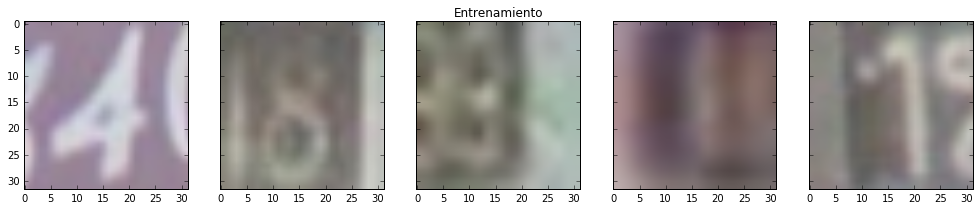

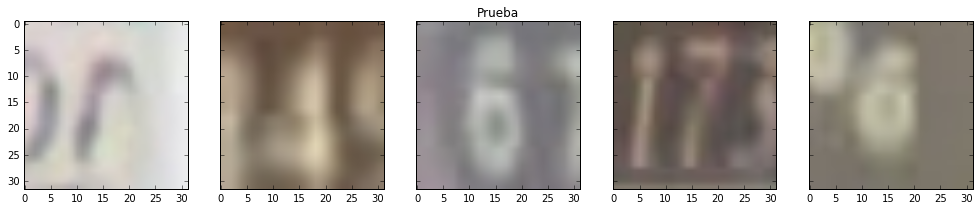

In [54]:
print "Visualizacion de imagenes aleatorias:"
f, ax = plt.subplots(1, 5, sharey=True, figsize=(17,3))
ax[2].set_title("Entrenamiento")
for i in range(5):
    ax[i].imshow(resize_img(random.choice(X_train)))
f, ax = plt.subplots(1, 5, sharey=True, figsize=(17,3))
ax[2].set_title("Prueba")
for i in range(5):
    ax[i].imshow(resize_img(random.choice(X_test)))

Como comentario, podemos decir que las imágenes vienen en un formato no adecuado para su visualización, por lo que fue necesario crear la funcion resize_img() para darles las dimensiones correctas. Por otro lado, se ve que las imágenes son bastante "borrosas", incluso no puediendo el ojo humano decifrar el número que aparece en algunas de ellas, por lo que es bastante interesante y motivador el hecho de descubrir lo que una red neuronal puede lograr respecto a este problema de clasificación.

<div id='b'/>
### Parte (b)

In [58]:
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

<div id='c'/>
### Parte (c)

In [60]:
n_channels = X_train.shape[1]
n_rows = X_train.shape[2]
n_cols = X_train.shape[3]
model = Sequential()
model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu',input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, 7, 7, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 32L, 32L)  1216        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16L, 16L)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 512, 16L, 16L) 401920      maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 512, 8L, 8L)   0           convolution2d_2[0][0]            
___________________________________________________________________________________________

<div id='d'/>
### Parte (d)

In [64]:
model.compile(loss='binary_crossentropy', optimizer=Adagrad, metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1280, nb_epoch=12, verbose=0, validation_data=(X_test, Y_test))

ERROR (theano.gof.opt): Optimization failure due to: local_abstractconv_check
ERROR (theano.gof.opt): node: AbstractConv2d{border_mode='half', subsample=(1, 1), filter_flip=True, imshp=(None, None, None, None), kshp=(16, 3, 5, 5), filter_dilation=(1, 1)}(convolution2d_input_1, convolution2d_1_W)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "C:\Users\Alvaro\Anaconda2\lib\site-packages\theano\gof\opt.py", line 1820, in process_node
    replacements = lopt.transform(node)
  File "C:\Users\Alvaro\Anaconda2\lib\site-packages\theano\tensor\nnet\opt.py", line 409, in local_abstractconv_check
    node.op.__class__.__name__)
AssertionError: AbstractConv2d Theano optimization failed: there is no implementation available supporting the requested options. Did you exclude both "conv_dnn" and "conv_gemm" from the optimizer? If on GPU, is cuDNN available and does the GPU support it? If on CPU, do you have a BLAS library installed Theano can link

AssertionError: AbstractConv2d Theano optimization failed: there is no implementation available supporting the requested options. Did you exclude both "conv_dnn" and "conv_gemm" from the optimizer? If on GPU, is cuDNN available and does the GPU support it? If on CPU, do you have a BLAS library installed Theano can link against?

<div id='e'/>
### Parte (e)

<div id='f'/>
### Parte (f)

<div id='g'/>
### Parte (g)

<div id='h'/>
### Parte (h)

<div id='i'/>
### Parte (i)

<div id='j'/>
### Parte (j)